# TMB and CCF analysis

In [1]:
import pandas as pd
import json
import pybedtools
from tqdm.notebook import trange, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
%matplotlib inline 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
samples = json.load( open( "../../../cases_ids.json", "rb" ) )

In [4]:
root_in_hmf = '/path/to/hmf_pipeline/output/'
root_in_sarek = '/path/to/sarek/output/'
root_out = './output/'

## Functions

In [5]:
def cnv_snvs_intersect (cnv_df,snvs_df):
    '''Adds CN information in snvs/indels mafs
    input: cn dataframe from ASCAT output (.cnvs.txt) and snvs/indels dataframe from maf files
    output: dataframe with integrated CN info to vc mafs'''
    

    cnv_bt_df = cnv_df.copy(deep=True)
    cnv_bt_df = cnv_bt_df.rename(columns={'chromosome':'chrom','copyNumber':'CN'})
    cnv_bt_df = cnv_bt_df[['chrom','start','end','CN']]
    #Prepare snvs_df
    snvs_bt_df = snvs_df.copy(deep=True)
    snvs_bt_df['POS2'] = snvs_bt_df['POS'] + 1
    snvs_bt_df = snvs_bt_df[['#CHROM','POS','POS2','REF','ALT']]

    #pybedtools cnv + snvs
    cnv_bt = pybedtools.BedTool.from_dataframe(cnv_bt_df)
    snvs_bt = pybedtools.BedTool.from_dataframe(snvs_bt_df)

    cnv_and_snvs = cnv_bt.intersect(snvs_bt)

    #Pass intersection to dataframe
    snvs_cnv_df = cnv_and_snvs.to_dataframe(header=None)
    columns= ['#CHROM','POS','POS2','CN'] 
    snvs_cnv_df = snvs_cnv_df.rename(columns={'chrom':'#CHROM','start':'POS','end':'POS2',
                                              'name':'CN'})
    snvs_cnv_df = snvs_cnv_df.drop(columns=['POS2'])

    #Merge intersect with snvs_df
    snvs_cnv_df = pd.merge(snvs_df,snvs_cnv_df,how='left')
    
    return snvs_cnv_df

def calculate_VAF(reads_alt,reads_ref):
    '''Calculate VAF from number of reads
    input: number of reads alternate allele, number of reads reference allele
    output: variant allele frequency'''
    if reads_alt == reads_ref == 0:
        return 0
    else:
        vaf = round (reads_alt/(reads_alt+reads_ref),3)
        return vaf

def calculate_ccf (vaf,cnv,purity):
    '''Calculate CCF from VAF, CN and purity
    input: variant allele frequency, copy number, purity
    output: cancer cell fraction'''
    ccf = vaf*(purity*cnv+ (1-purity)*2)/purity
    return ccf

def final_dataframe (root_in_sarek,root_in_hmf,root_out,tumor,normal):
    '''Reads vc mafs and ASCAT output, makes intersect snvs and CN and adds columns calculated 
    with VAF and CCF
    input: patient, tumor sample id, normal sample id and caller type
    output: final dataframe with CN, VAF and CCF information added'''
    
    #Read cnv callings (purple)
    
    cnv_df = pd.read_csv(root_in_hmf+'/purple/'+tumor+'.purple.cnv.somatic.tsv',sep='\t')          
        
    purity = pd.read_csv(root_in_hmf+'/purple/'
                         +tumor+'.purple.purity.tsv',sep='\t')
    #Get purity
    purity = purity['purity'][0]
    

    snvs_df = pd.read_csv(root_out
                              +tumor+'_vs_'+normal+'/process_vep_output/'
                              +tumor+'_vs_'+normal+'.maf.gz',sep='\t')
    
    #Get df with cn and snv intersect

    df = cnv_snvs_intersect(cnv_df,snvs_df)    

    #Calculate AF and CCF
    df['t_AF'] = df.apply(lambda row: calculate_VAF(row['t_alt_reads'],row['t_ref_reads']),axis=1)
    df['n_AF'] = df.apply(lambda row: calculate_VAF(row['n_alt_reads'],row['n_ref_reads']),axis=1)
    df['t_CCF'] = df.apply(lambda row: calculate_ccf(row['t_AF'],row['CN'],purity),axis=1)
    df['n_CCF'] = df.apply(lambda row: calculate_ccf(row['n_AF'],row['CN'],purity),axis=1)
    df['purity'] = purity
    
    return df

### Case 1

In [6]:
#Tumor1

root_in_sarek = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt2-t1-allsamples-t1/sarek_results/results/'
root_in_hmf = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt2-t1-allsamples-t1/'
root_out = '/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/pt2/' #root_out + 'case1'

pt = 'case1'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
case1_t1_df = final_dataframe(root_in_sarek,root_in_hmf,root_out,tumor,normal)

#Tumor2

root_in_sarek = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt2-t2-allsamples-t2/sarek_results/results/'
root_in_hmf = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt2-t2-allsamples-t2/'

tumor = samples[pt]['tumor2']
case1_t2_df = final_dataframe(root_in_sarek,root_in_hmf,root_out,tumor,normal)

### Case 2

In [7]:
#Tumor1

root_in_sarek = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt3-t1-allsamples-t1/sarek_results/results/'
root_in_hmf = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt3-t1-allsamples-t1/'
root_out = '/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/pt3/' #root_out + 'case1'

pt = 'case2'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
case2_t1_df = final_dataframe(root_in_sarek,root_in_hmf,root_out,tumor,normal)

#Tumor2

root_in_sarek = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt3-t2-allsamples-t2/sarek_results/results/'
root_in_hmf = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt3-t2-allsamples-t2/'

tumor = samples[pt]['tumor2']
case2_t2_df = final_dataframe(root_in_sarek,root_in_hmf,root_out,tumor,normal)

### Case 3

In [8]:
#Tumor1

root_in_sarek = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt1-t1-allsamples-t1/sarek_results/results/'
root_in_hmf = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt1-t1-allsamples-t1/'
root_out = '/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/pt1/' #root_out + 'case1'

pt = 'case3'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
case3_t1_df = final_dataframe(root_in_sarek,root_in_hmf,root_out,tumor,normal)

#Tumor2

root_in_sarek = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt1-t2-allsamples-t2/sarek_results/results/'
root_in_hmf = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt1-t2-allsamples-t2/'

tumor = samples[pt]['tumor2']
case3_t2_df = final_dataframe(root_in_sarek,root_in_hmf,root_out,tumor,normal)

### Case 4

In [9]:
#Tumor1

root_in_sarek = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt8-t1-allsamples-t1/sarek_results/results/'
root_in_hmf = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt8-t1-allsamples-t1/'
root_out = '/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/pt8/' #root_out + 'case1'

pt = 'case4'
tumor = samples[pt]['tumor1']
normal = samples[pt]['normal']
case4_t1_df = final_dataframe(root_in_sarek,root_in_hmf,root_out,tumor,normal)

#Tumor2

root_in_sarek = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt8-t2-allsamples-t2/sarek_results/results/'
root_in_hmf = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt8-t2-allsamples-t2/'

tumor = samples[pt]['tumor2']
case4_t2_df = final_dataframe(root_in_sarek,root_in_hmf,root_out,tumor,normal)

## Plots

### Tumor mutational burden

In [10]:
import os

In [11]:
samples_list = [case1_t1_df,case1_t2_df,
                case2_t1_df,case2_t2_df,
                case3_t1_df,case3_t2_df,
                case4_t1_df,case4_t2_df]

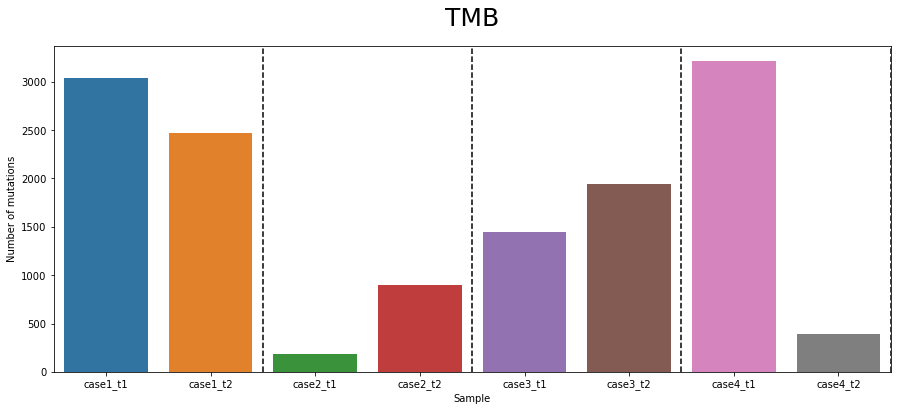

In [12]:
import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

tum_burden = []
for df in samples_list:
    sample_name = [ n for n in retrieve_name(df) if 'case' in n]
    sample_name = sample_name[0].split('_df')[0]
    sample_final = []
    sample_final.append(sample_name)
    sample_final.append(len(df[df['gnomADg_AF']<0.001]))
    tum_burden.append(sample_final)
tum_burden_df = pd.DataFrame(tum_burden,columns=['Sample','Number of mutations'])
plt.figure(figsize=(15,6))
sns.barplot(tum_burden_df['Sample'],tum_burden_df['Number of mutations'])
plt.title('TMB',size=25,pad=20)
pos=1.5
while pos<8:
    plt.axvline(x=pos,color='k',linestyle='--')
    pos = pos + 2

### Density plots

In [13]:
def get_ccf_threshold (data,sample,title):
    '''get threshold for clonal fraction of the variants
    input: data table per sample
    output: float, t_CCF value'''
    purity = data['purity'][0]
    def slope(data_y,data_x,i):
        slope = (data_y[i+1] - data_y[i]) / (data_x[i+1] - data_x[i])
        return slope
    y_var='t_CCF'
    xlim=3
    data = data[(~data[y_var].isnull())&(data['t_CCF']<xlim)]
    data = data[y_var]
    fig, ax = plt.subplots()
    fig.set_size_inches(4, 2)
    ax = sns.distplot(data,rug=True,bins=50)
    data_x, data_y = ax.lines[0].get_data()

    poss = []
    for i in range(len(data_y)):
        if i == 0 or i == (len(data_y)-1):
            pass
        else:
            if sample == 'case3_t2':
                if  slope(data_y,data_x,i)<0.8 and slope(data_y,data_x,i)>0.7:
                    pos = i
                    poss.append(pos)
            elif sample == 'case2_t2':
                if  slope(data_y,data_x,i)<-0.8 and slope(data_y,data_x,i)>-0.9:
                    pos = i
                    poss.append(pos)
            else:
                if (data_y[i] < data_y[i+1]) and (data_y[i] < data_y[i-1]):
                    poss.append(i)
#                     print(data_y[i],i)
    poss = [pos for pos in poss if data_x[pos] <1]
    if poss == []:
        pos = 0
    else:
        pos = max(poss)
        
    plt.axhline(y = data_y[pos],color='k',linewidth=1,linestyle='--')
    plt.axvline(x = data_x[pos],color='k',linewidth=1,linestyle='--')
    plt.text(data_x[pos]+0.1,data_y.max(),'Clonal',size=14)
    plt.text(data_x.max()*0.7,data_y.max(),'Purity = '+str(purity))
    ax.set_title(title,size=20,pad=20)

    return data_x[pos]

{'case1_t1': 0.6057787222048805,
 'case1_t2': 0.5363311165234896,
 'case2_t1': 0.4880408661925021,
 'case2_t2': 0.6594260071476463,
 'case3_t1': 0.4795411737486141,
 'case3_t2': 0.5113676352736383,
 'case4_t1': 0.49050357099165653,
 'case4_t2': 0.4758741534200194}

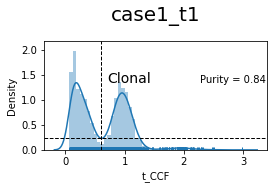

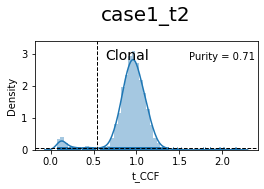

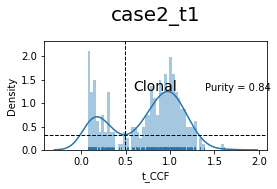

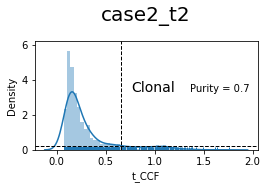

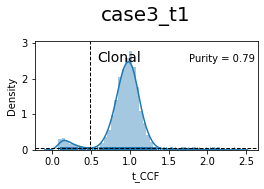

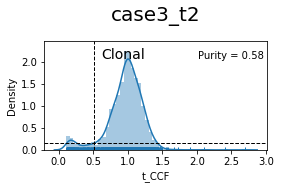

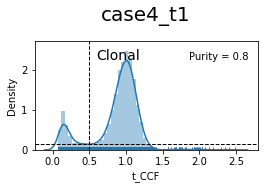

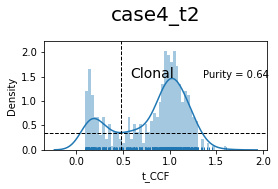

In [14]:
thresholds = {}
for df in samples_list:
    sample_name = [ n for n in retrieve_name(df) if 'case' in n]
    sample_name = sample_name[0].split('_df')[0]
    threshold = get_ccf_threshold(df,sample_name,sample_name)
    thresholds[sample_name] = threshold
thresholds

In [15]:
thresholds

{'case1_t1': 0.6057787222048805,
 'case1_t2': 0.5363311165234896,
 'case2_t1': 0.4880408661925021,
 'case2_t2': 0.6594260071476463,
 'case3_t1': 0.4795411737486141,
 'case3_t2': 0.5113676352736383,
 'case4_t1': 0.49050357099165653,
 'case4_t2': 0.4758741534200194}

In [16]:
json.dump(thresholds, open( "ccf_thresholds.json", "w" ) )

### Check TMB separating clonals vs. subclonals
y axis is on the same length (3000 mutations)

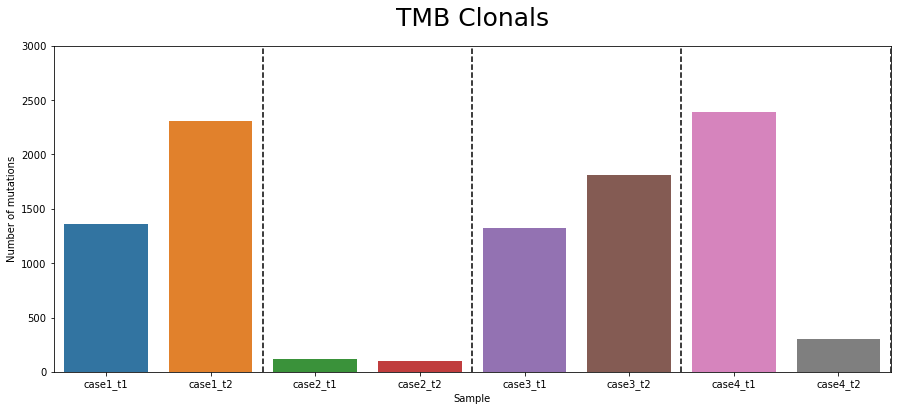

In [20]:
tum_burden = []
for df in samples_list:
    sample_name = [ n for n in retrieve_name(df) if 'case' in n]
    sample_name = sample_name[0].split('_df')[0]
    sample_final = []
    sample_final.append(sample_name)
    ccf_threshold = thresholds[sample_name]
    sample_final.append(len(df[(df['gnomADg_AF']<0.001)&(df['t_CCF']>ccf_threshold)]))
    tum_burden.append(sample_final)
tum_burden_df = pd.DataFrame(tum_burden,columns=['Sample','Number of mutations'])
plt.figure(figsize=(15,6))
sns.barplot(tum_burden_df['Sample'],tum_burden_df['Number of mutations'])
plt.title('TMB Clonals',size=25,pad=20)
plt.ylim(0,3000)
pos=1.5
while pos<8:
    plt.axvline(x=pos,color='k',linestyle='--')
    pos = pos + 2

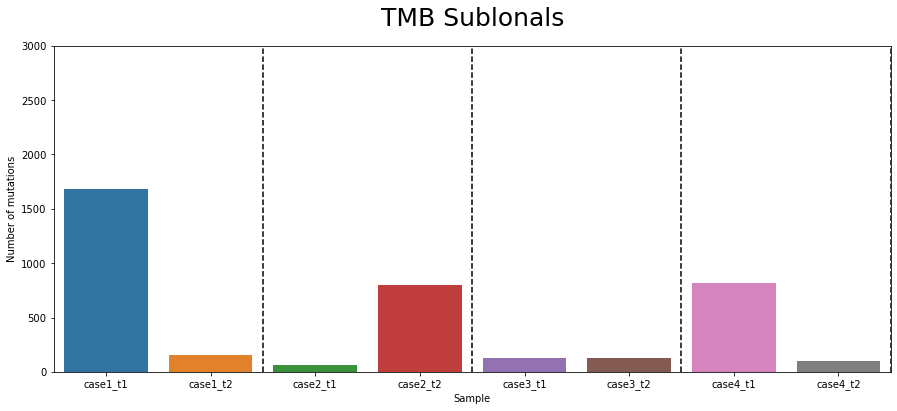

In [21]:
tum_burden = []
for df in samples_list:
    sample_name = [ n for n in retrieve_name(df) if 'case' in n]
    sample_name = sample_name[0].split('_df')[0]
    sample_final = []
    sample_final.append(sample_name)
    ccf_threshold = thresholds[sample_name]
    sample_final.append(len(df[(df['gnomADg_AF']<0.001)&(df['t_CCF']<ccf_threshold)]))
    tum_burden.append(sample_final)
tum_burden_df = pd.DataFrame(tum_burden,columns=['Sample','Number of mutations'])
plt.figure(figsize=(15,6))
sns.barplot(tum_burden_df['Sample'],tum_burden_df['Number of mutations'])
plt.title('TMB Sublonals',size=25,pad=20)
plt.ylim(0,3000)
pos=1.5
while pos<8:
    plt.axvline(x=pos,color='k',linestyle='--')
    pos = pos + 2

### Density plots for figures

In [22]:
import matplotlib as mpl
import numpy as np

In [23]:
def density_plot_paper (df,y_var,xlim1,xlim2,ylim1,ylim2,yticks,xticks,sample_id,bins=100,position=2):
    '''Create density plot for CCF
    input: tumor data, title and xlim max
    output: plot()'''
    
    def slope(data_y,data_x,i):
        slope = (data_y[i+1] - data_y[i]) / (data_x[i+1] - data_x[i])
        return slope
    purity = df['purity'][0]    
    df = df[(~df[y_var].isnull())&(df['t_CCF']<xlim2)]
    df = df[y_var]
    plt.figure(figsize=(3, 2))
    ax = sns.distplot(df,rug=True,bins=bins)
    plt.xlim(xlim1,xlim2)
    plt.yticks(yticks)
    plt.xticks(xticks)
    plt.ylabel('Density', fontsize=16)
    plt.xlabel('CCF', fontsize=16)

    data_x, data_y = ax.lines[0].get_data()

    poss = []
    for i in range(len(data_y)):
        if i == 0 or i == (len(data_y)-1):
            pass
        else:
            if sample_id == 'case3_t2':
                if  slope(data_y,data_x,i)<0.8 and slope(data_y,data_x,i)>0.7:
                    pos = i
                    poss.append(pos)
            elif sample_id == 'case2_t2':
                if  slope(data_y,data_x,i)<-0.8 and slope(data_y,data_x,i)>-0.9:
                    pos = i
                    poss.append(pos)
            else:
                if (data_y[i] < data_y[i+1]) and (data_y[i] < data_y[i-1]):
                    poss.append(i)

    poss = [pos for pos in poss if data_x[pos] <1]
    if poss == []:
        pos = 0
    else:
        pos = max(poss)


    plt.axvline(x = data_x[pos],color='k',linewidth=1.5,linestyle='--')

    mpl.rcParams['axes.spines.right'] = False
    mpl.rcParams['axes.spines.top'] = False

### Case 1

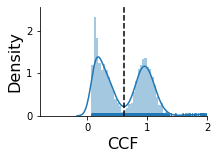

In [26]:
sample_id='case1_t1'
df = case1_t1_df.copy(deep=False)
y_var = 't_CCF'
xlim1 = -0.8
xlim2 = 2
ylim2 = 3
yticks = np.arange (0, 3, 1)
xticks = np.arange(0, 3, 1)

density_plot_paper(df=df,y_var=y_var,xlim1=xlim1,xlim2=xlim2,ylim1=0,ylim2=ylim2,xticks=xticks,yticks=yticks,sample_id=sample_id,bins=50, position=0)        
plt.savefig(sample_id+'_ccf_distr.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()


In [27]:
#Check number of clonal and subclonal snv mutations

threshold = thresholds['case1_t1']

df = case1_t1_df.copy()

df['clonal'] = df['t_CCF'].apply(lambda x: True if x > threshold else False)

df = df[(df['mut_type']=='snv')&(df['gnomADg_AF']<1)].drop_duplicates(subset=['#CHROM','POS','REF','ALT'])
df[['#CHROM','POS','REF','ALT','clonal']].groupby('clonal').count()

,#CHROM,POS,REF,ALT
clonal,,,,
False,1644,1644,1644,1644
True,1259,1259,1259,1259


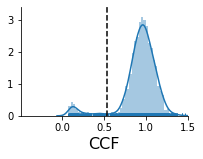

In [28]:
sample_id='case1_t2'
df = case1_t2_df.copy(deep=False)
y_var = 't_CCF'
xlim1 = -0.5
xlim2 = 1.5
ylim2 = 3
yticks = np.arange (0, 3+1, 1)
xticks = np.arange(0, 2, 0.5)

density_plot_paper(df=df,y_var=y_var,xlim1=xlim1,xlim2=xlim2,ylim1=0,ylim2=ylim2,xticks=xticks,yticks=yticks,sample_id=sample_id,bins=50, position=0)        
plt.ylabel('')
plt.savefig(sample_id+'_ccf_distr.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()


In [29]:
#Check number of clonal and subclonal snv mutations

threshold = thresholds['case1_t2']

df = case1_t2_df.copy()

df['clonal'] = df['t_CCF'].apply(lambda x: True if x > threshold else False)

df = df[(df['mut_type']=='snv')&(df['gnomADg_AF']<1)].drop_duplicates(subset=['#CHROM','POS','REF','ALT'])
df[['#CHROM','POS','REF','ALT','clonal']].groupby('clonal').count()

,#CHROM,POS,REF,ALT
clonal,,,,
False,165,165,165,165
True,2231,2231,2231,2231


### Case 2

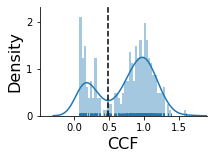

In [30]:
sample_id='case2_t1'
df = case2_t1_df.copy(deep=False)
y_var = 't_CCF'
xlim2 = 1.9
ylim2 = 3
yticks = np.arange (0, 3, 1)
xticks = np.arange(0, 2, 0.5)

density_plot_paper(df=df,y_var=y_var,xlim1=xlim1,xlim2=xlim2,ylim1=0,ylim2=ylim2,xticks=xticks,yticks=yticks,sample_id=sample_id,bins=50, position=0)        
plt.savefig(sample_id+'_ccf_distr.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()


In [31]:
#Check number of clonal and subclonal snv mutations

threshold = thresholds['case2_t1']

df = case2_t1_df.copy()

df['clonal'] = df['t_CCF'].apply(lambda x: True if x > threshold else False)

df = df[(df['mut_type']=='snv')&(df['gnomADg_AF']<1)].drop_duplicates(subset=['#CHROM','POS','REF','ALT'])
df[['#CHROM','POS','REF','ALT','clonal']].groupby('clonal').count()

,#CHROM,POS,REF,ALT
clonal,,,,
False,67,67,67,67
True,111,111,111,111


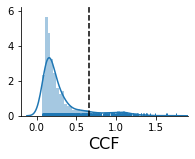

In [32]:
sample_id='case2_t2'
df = case2_t2_df.copy(deep=False)
y_var = 't_CCF'

xlim1 = -0.2
xlim2 = 1.9
ylim2 = 3
yticks = np.arange (0, 6+1, 2)
xticks = np.arange(0, 2, 0.5)

density_plot_paper(df=df,y_var=y_var,xlim1=xlim1,xlim2=xlim2,ylim1=0,ylim2=ylim2,xticks=xticks,yticks=yticks,sample_id=sample_id,bins=50, position=0)        
plt.ylabel('')
plt.savefig(sample_id+'_ccf_distr.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()


In [33]:
#Check number of clonal and subclonal snv mutations

threshold = thresholds['case2_t2']

df = case2_t2_df.copy()

df['clonal'] = df['t_CCF'].apply(lambda x: True if x > threshold else False)

df = df[(df['mut_type']=='snv')&(df['gnomADg_AF']<1)].drop_duplicates(subset=['#CHROM','POS','REF','ALT'])
df[['#CHROM','POS','REF','ALT','clonal']].groupby('clonal').count()

,#CHROM,POS,REF,ALT
clonal,,,,
False,1024,1024,1024,1024
True,94,94,94,94


### Case 3

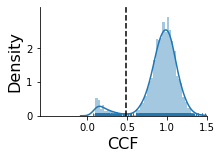

In [34]:
sample_id='case3_t1'
df = case3_t1_df.copy(deep=False)
y_var = 't_CCF'
xlim1 = -0.6
xlim2 = 1.5
ylim2 = 3
yticks = np.arange (0, 3, 1)
xticks = np.arange(0, 2, 0.5)

density_plot_paper(df=df,y_var=y_var,xlim1=xlim1,xlim2=xlim2,ylim1=0,ylim2=ylim2,xticks=xticks,yticks=yticks,sample_id=sample_id,bins=50, position=0)        
plt.savefig(sample_id+'_ccf_distr.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()


In [35]:
#Check number of clonal and subclonal snv mutations

threshold = thresholds['case3_t1']

df = case3_t1_df.copy()

df['clonal'] = df['t_CCF'].apply(lambda x: True if x > threshold else False)

df = df[(df['mut_type']=='snv')&(df['gnomADg_AF']<1)].drop_duplicates(subset=['#CHROM','POS','REF','ALT'])
df[['#CHROM','POS','REF','ALT','clonal']].groupby('clonal').count()

,#CHROM,POS,REF,ALT
clonal,,,,
False,128,128,128,128
True,1252,1252,1252,1252


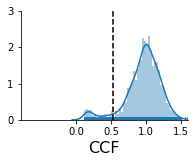

In [36]:
sample_id='case3_t2'
df = case3_t2_df.copy(deep=False)
y_var = 't_CCF'
xlim1 = -0.8
xlim2 = 1.6
yticks = np.arange (0, 3+1, 1)
xticks = np.arange(0, 2, 0.5)

density_plot_paper(df=df,y_var=y_var,xlim1=xlim1,xlim2=xlim2,ylim1=0,ylim2=ylim2,xticks=xticks,yticks=yticks,sample_id=sample_id,bins=50, position=0)        
plt.ylabel('')
plt.savefig(sample_id+'_ccf_distr.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()


In [38]:
#Check number of clonal and subclonal snv mutations

threshold = thresholds['case3_t2']

df = case3_t2_df.copy()

df['clonal'] = df['t_CCF'].apply(lambda x: True if x > threshold else False)

df = df[(df['mut_type']=='snv')&(df['gnomADg_AF']<1)].drop_duplicates(subset=['#CHROM','POS','REF','ALT'])
df[['#CHROM','POS','REF','ALT','clonal']].groupby('clonal').count()

,#CHROM,POS,REF,ALT
clonal,,,,
False,122,122,122,122
True,1579,1579,1579,1579
